In [ ]:
# Import required libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

# Custom tokenizer for financial text
def custom_tokenizer(text):
    # Split on special characters, numbers, and spaces
    tokens = re.split(r'[\\@\-\s\d]+', text)
    # Remove empty strings and normalize case
    return [token.strip().lower() for token in tokens if token.strip()]

# Enhanced preprocessing function
def preprocess_transaction_text(df):
    # Clean and tokenize text
    df['processed_text'] = df['Narration'].apply(
        lambda x: ' '.join(custom_tokenizer(x))
    )

    # Add transaction type markers
    transaction_types = ['UPI', 'NEFT', 'IMPS', 'ATM', 'POS', 'FD', 'CR', 'DR']
    for t_type in transaction_types:
        df['processed_text'] += ' ' + df['Narration'].str.contains(
            f'^{t_type}', case=False, regex=True
        ).replace({True: f'TXN_TYPE_{t_type}', False: ''})

    return df

# Load and prepare data
df = pd.read_csv('/content/classification-NLP.csv')
df = preprocess_transaction_text(df)

# Encode labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'],
    df['category_encoded'],
    test_size=0.2,
    stratify=df['category_encoded'],
    random_state=42
)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    ngram_range=(1, 2),
    max_features=3000,
    min_df=2,
    stop_words=None
)

# Create pipeline with increased iterations
model_pipeline = make_pipeline(
    tfidf,
    LogisticRegression(
        max_iter=2000,  # Increased from 1000
        class_weight='balanced',
        solver='saga',
        random_state=42
    )
)

# Train model
model_pipeline.fit(X_train, y_train)

# Predictions
y_pred = model_pipeline.predict(X_test)

# Decode labels
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Modified classification report section
# Get unique classes present in test data
present_classes = np.unique(np.concatenate([y_test_decoded, y_pred_decoded]))
target_names = [cls for cls in label_encoder.classes_ if cls in present_classes]

print("Classification Report:")
print(classification_report(
    y_test_decoded,
    y_pred_decoded,
    target_names=target_names,
    zero_division=0
))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Classification Report:
                    precision    recall  f1-score   support

               ATM       1.00      0.33      0.50         3
      Accomadation       0.75      0.50      0.60         6
  Account Transfer       1.00      0.71      0.83        28
             Bills       1.00      0.57      0.73         7
          Cashback       1.00      0.33      0.50         3
           Charges       1.00      1.00      1.00         2
         Education       1.00      1.00      1.00         1
     Entertainment       0.33      1.00      0.50         2
     Fixed Deposit       1.00      1.00      1.00         5
  Food & Groceries       0.30      0.54      0.39        13
              Fuel       1.00      1.00      1.00         2
        Investment       1.00      1.00      1.00         2
Medical/Healthcare       0.00      0.00      0.00         1
            Others       0.00      0.00      0.00         1
  Savings Interest       0.00      0.00      0.00         2
          Shoppi

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


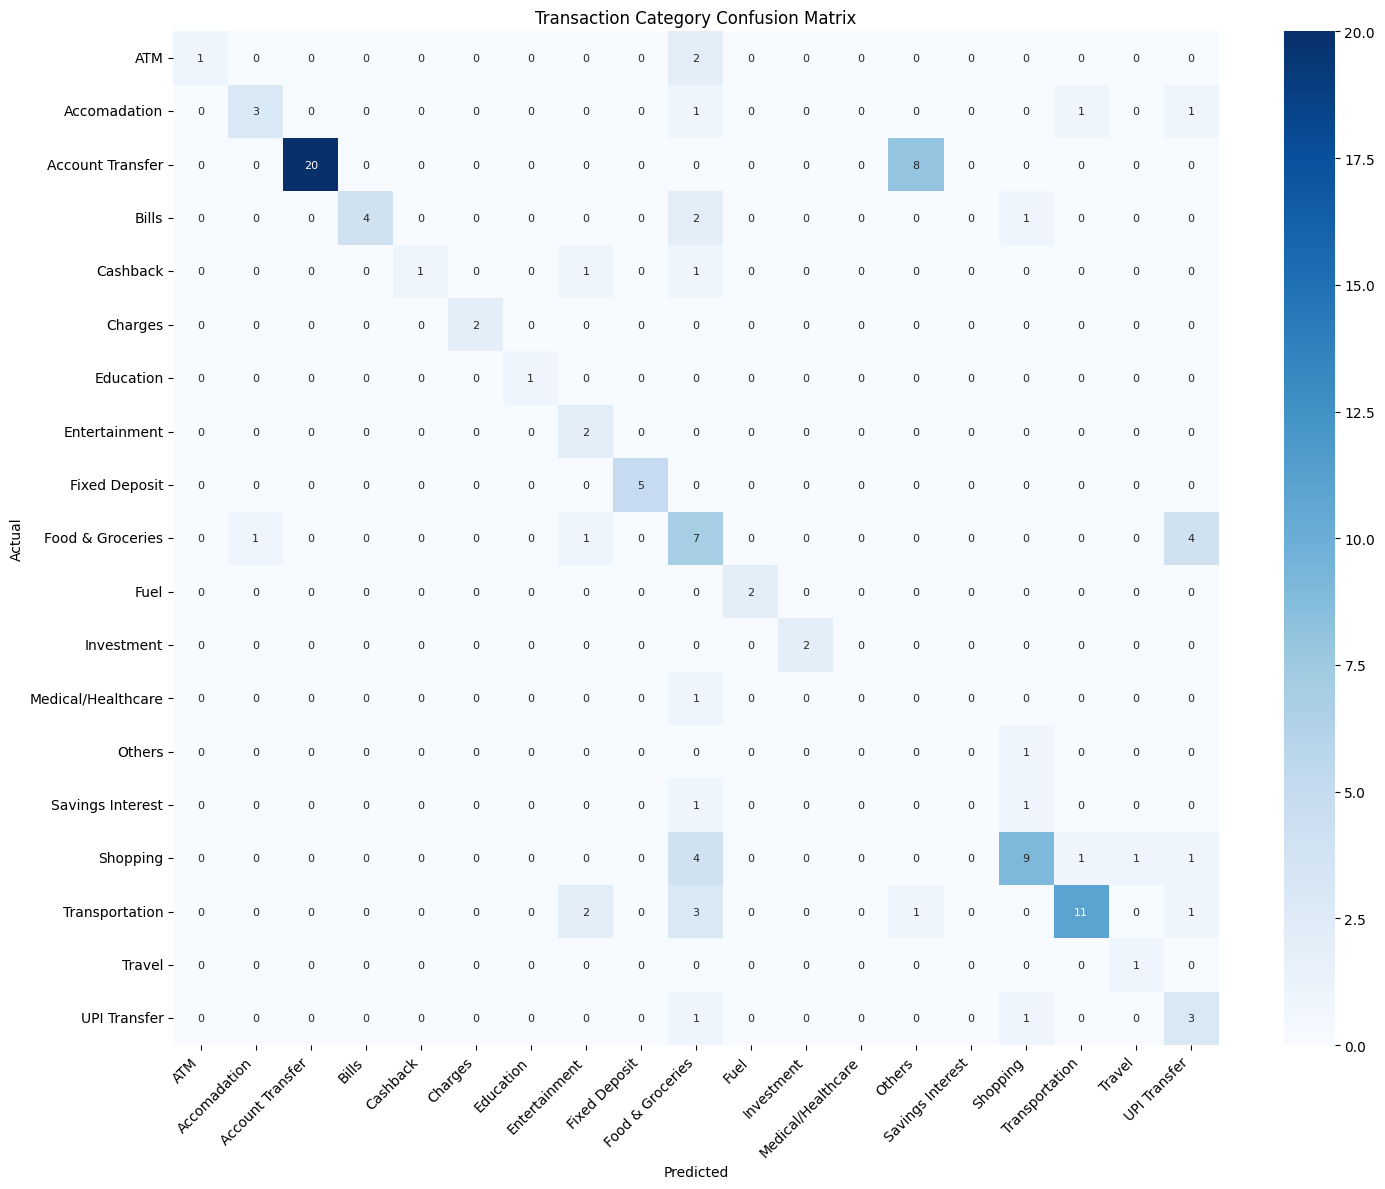

In [ ]:
# Update confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)  # Added labels parameter
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=classes,
                yticklabels=classes,
                cmap='Blues',
                annot_kws={'size': 8})
    plt.title('Transaction Category Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test_decoded, y_pred_decoded, target_names)

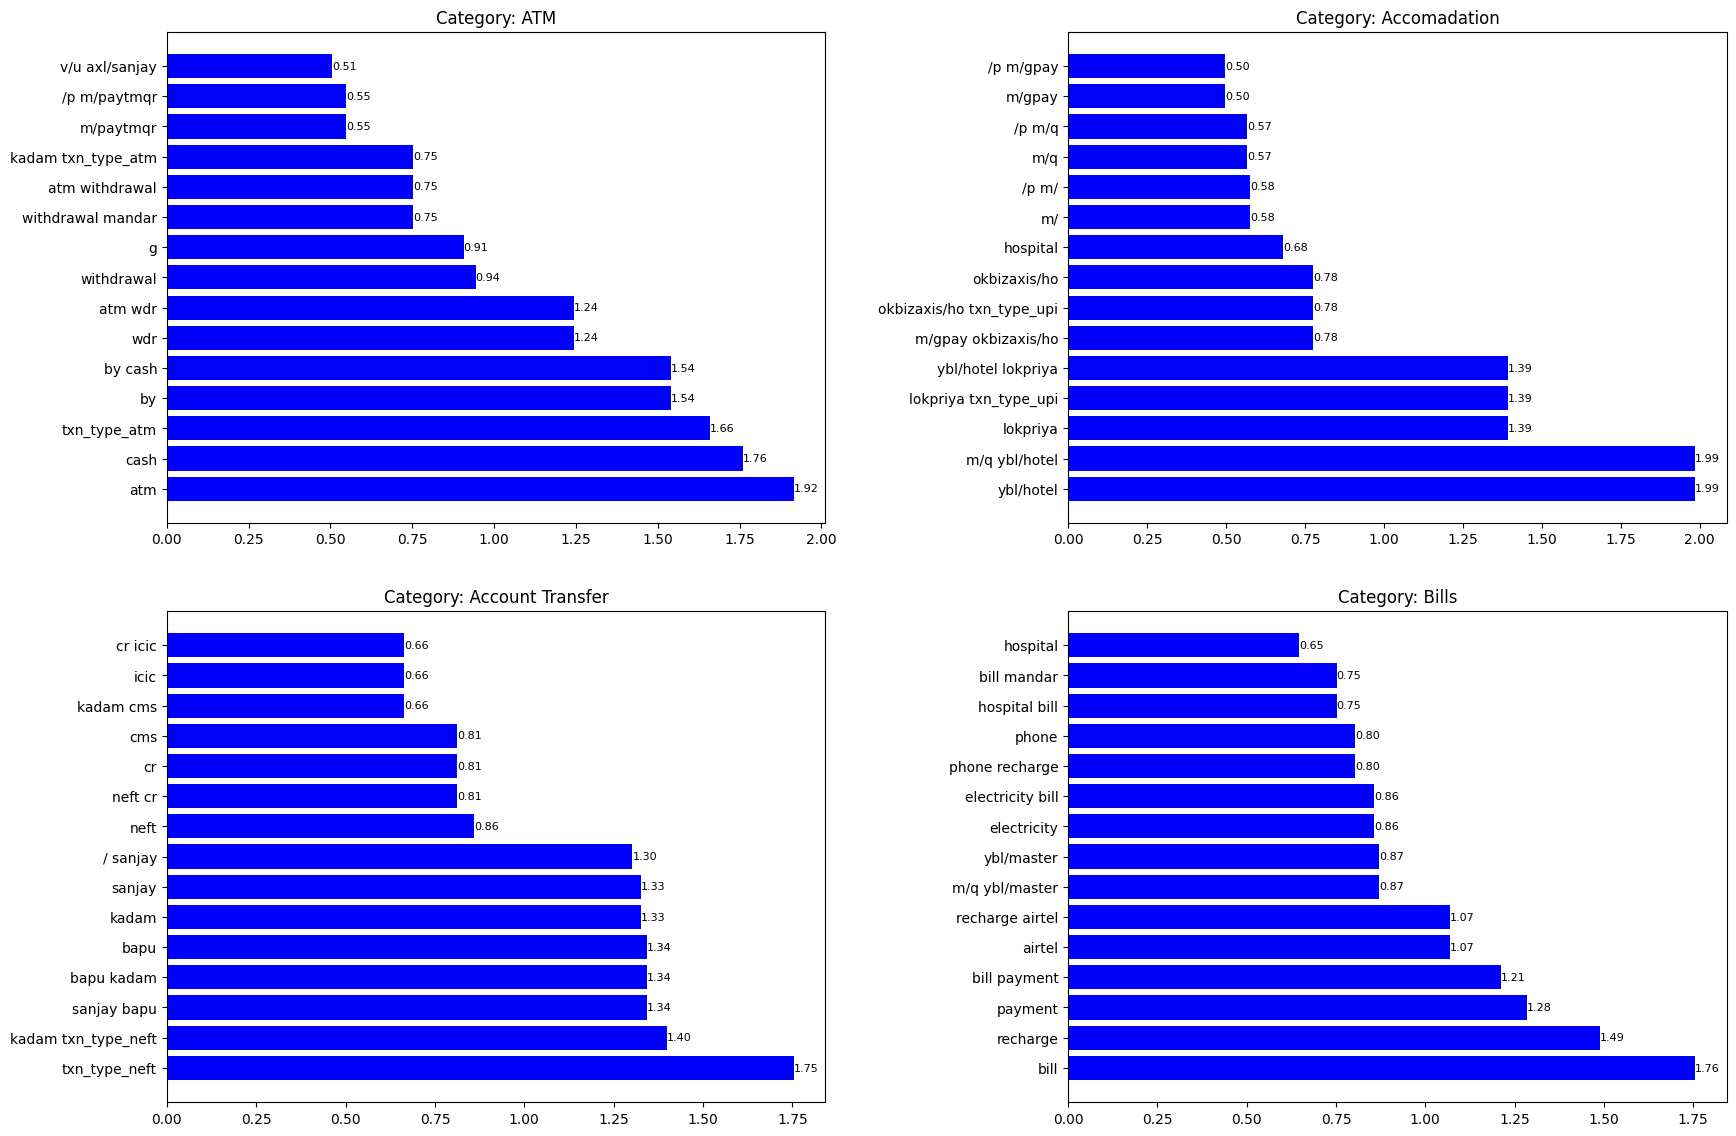

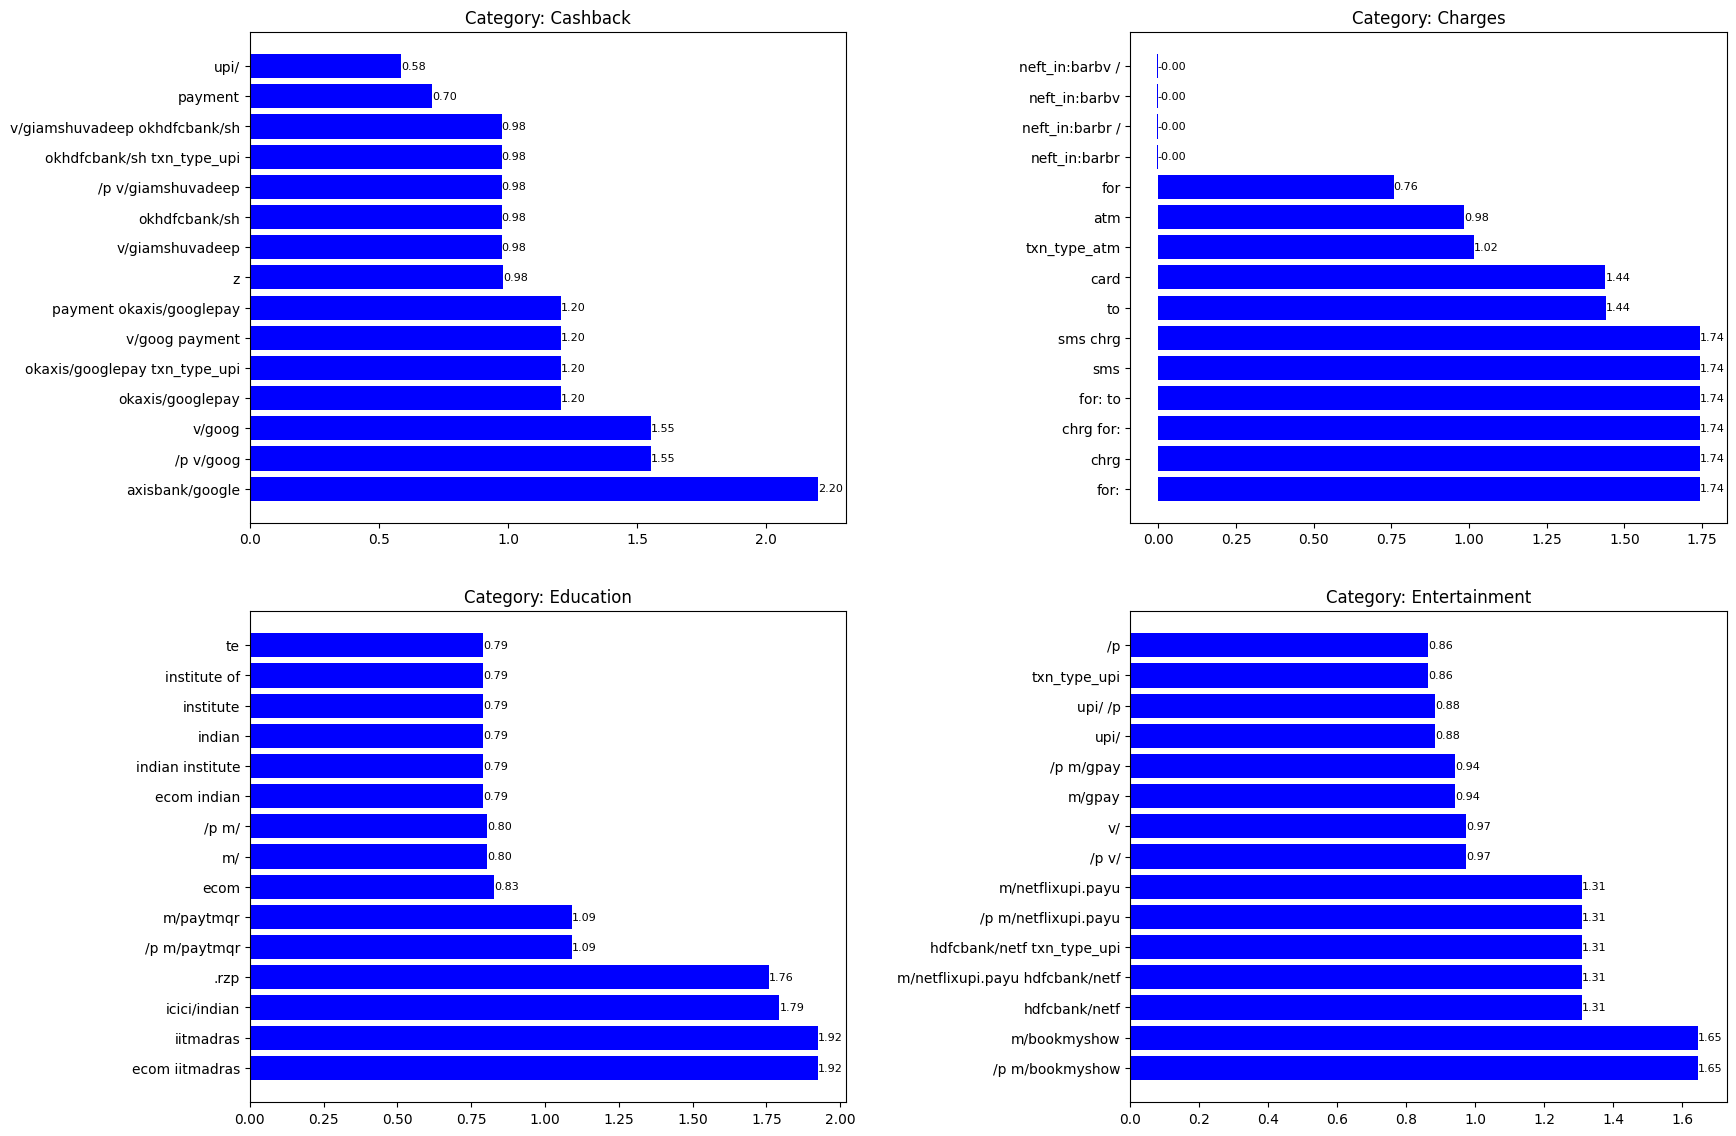

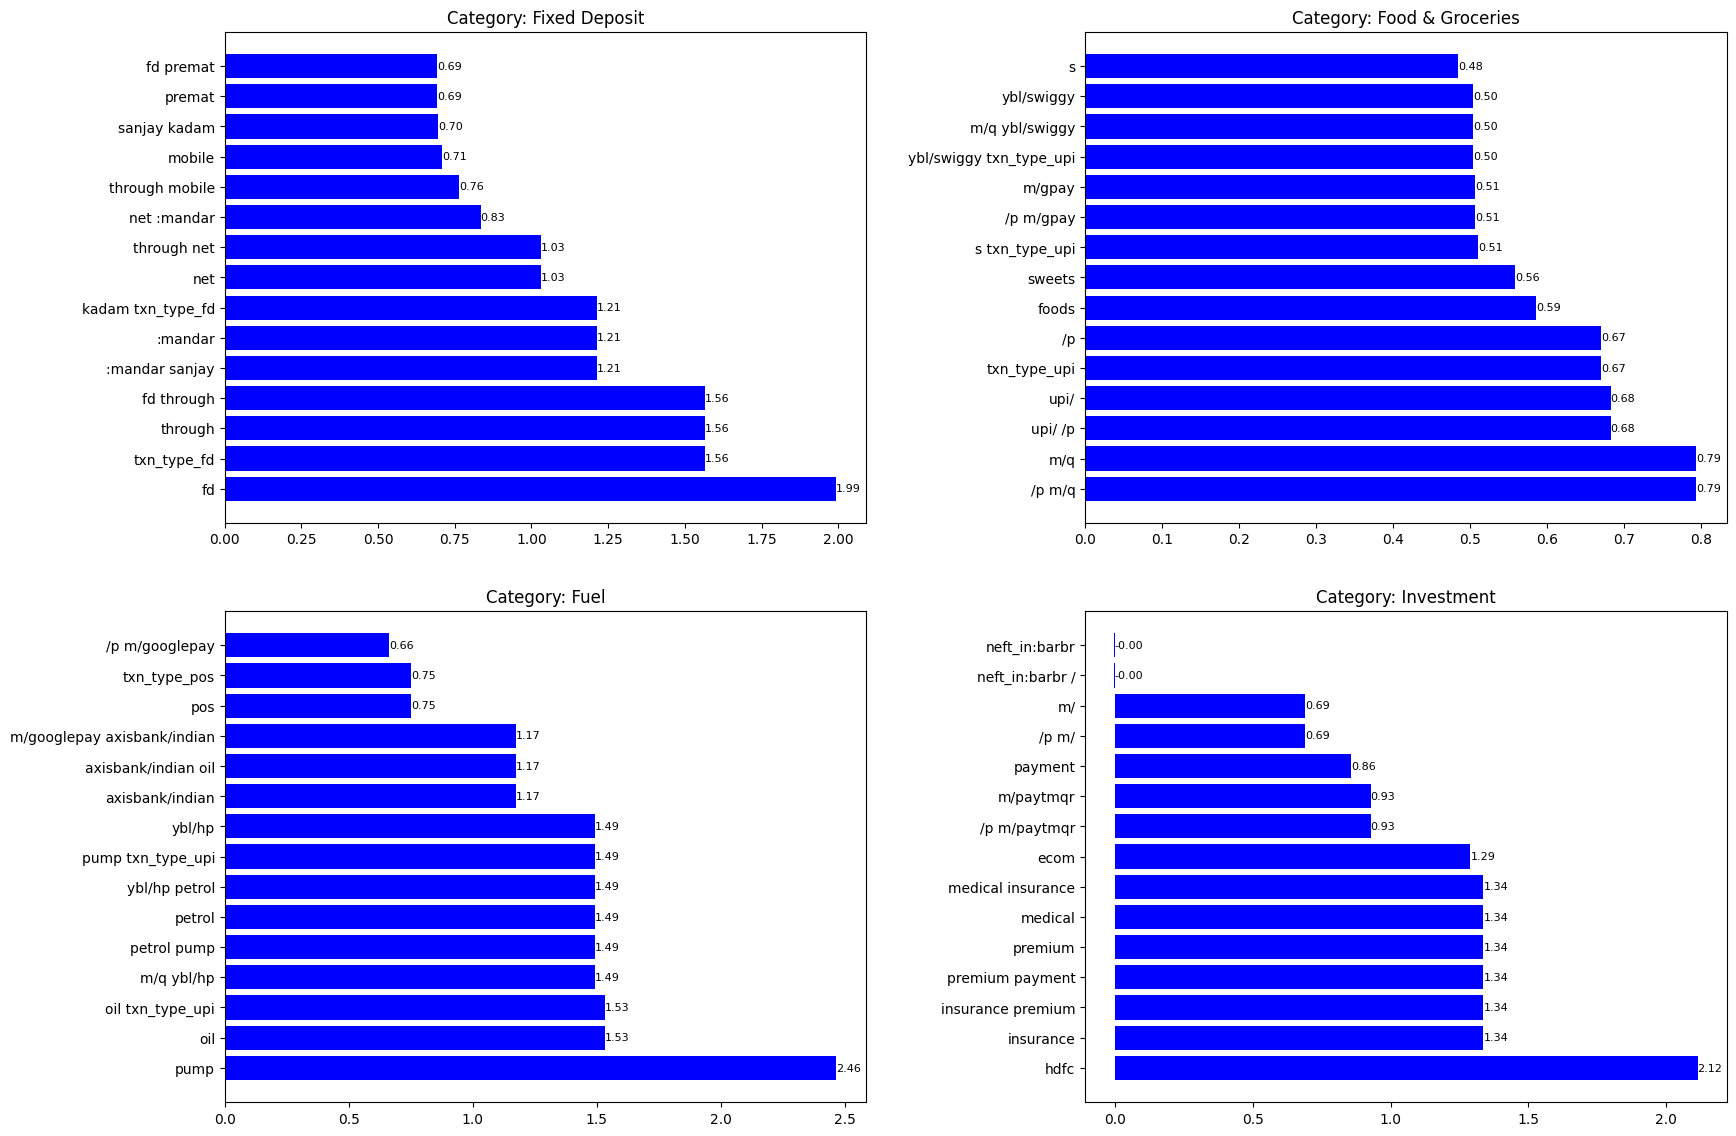

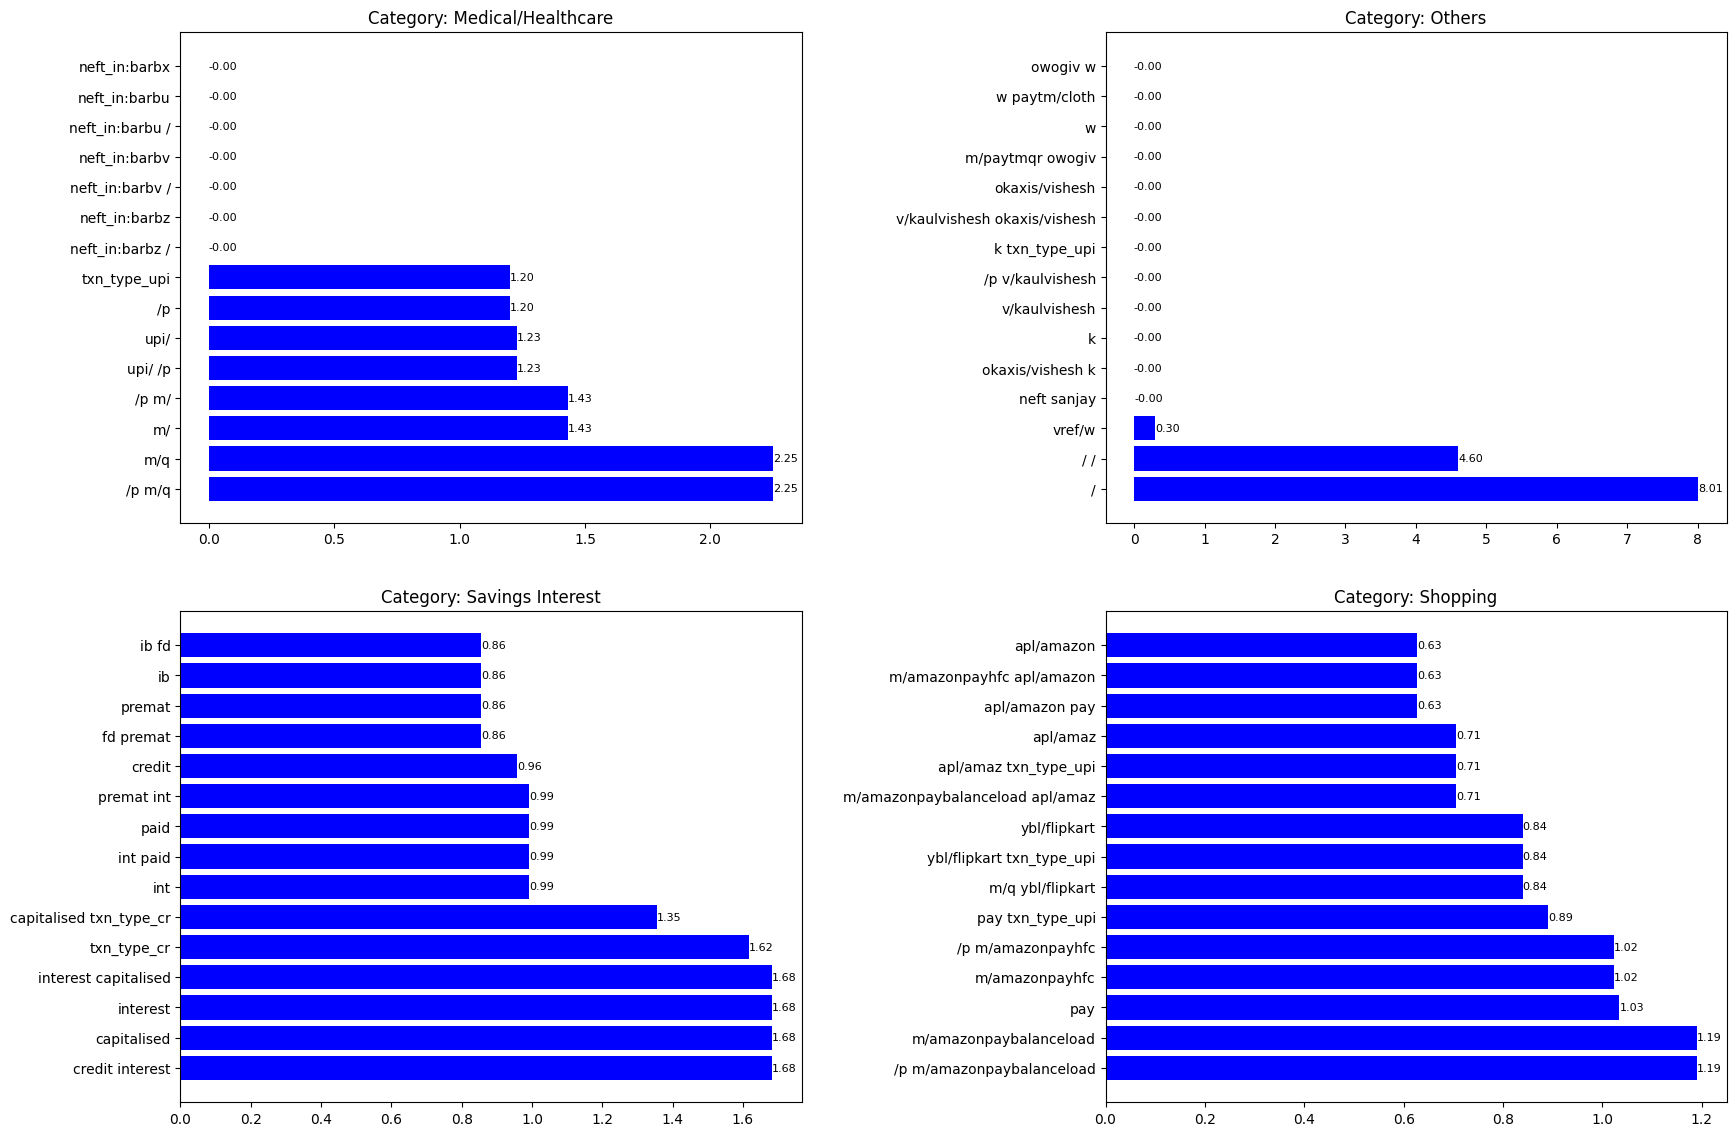

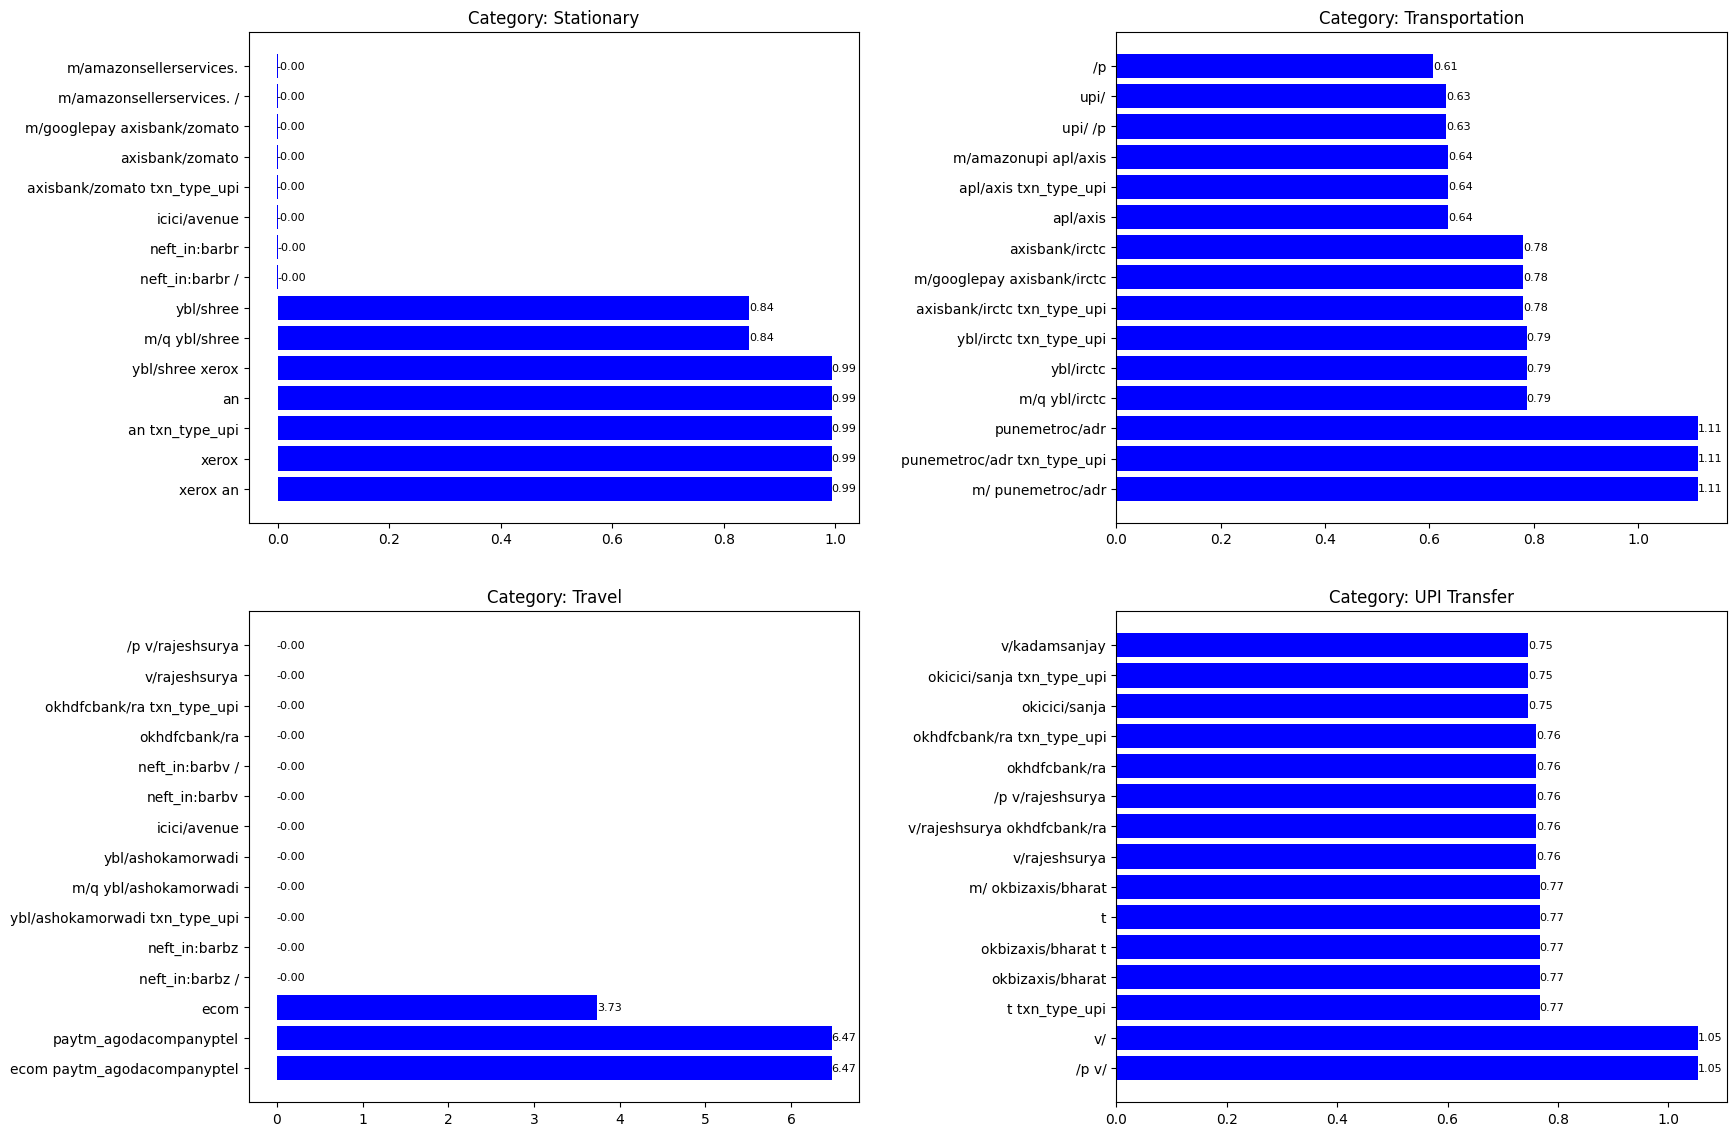

In [ ]:
def plot_feature_importance(pipeline, label_encoder, n=20):
    feature_names = pipeline.named_steps['tfidfvectorizer'].get_feature_names_out()
    classifier = pipeline.named_steps['logisticregression']

    # Calculate number of pages needed (4 categories per page)
    n_classes = len(label_encoder.classes_)
    n_pages = (n_classes + 3) // 4  # Round up division

    for page in range(n_pages):
        plt.figure(figsize=(18, 12))  # Adjusted figure size

        # Get the classes for this page
        start_idx = page * 4
        end_idx = min((page + 1) * 4, n_classes)
        page_classes = label_encoder.classes_[start_idx:end_idx]

        # Create 2x2 grid for 4 categories
        for idx, class_name in enumerate(page_classes, 1):
            plt.subplot(2, 2, idx)
            class_index = np.where(label_encoder.classes_ == class_name)[0][0]
            coefs = classifier.coef_[class_index]

            # Get top features
            top_features = np.argsort(coefs)[-n:]
            colors = ['red' if 'TXN_TYPE' in feature_names[f] else 'blue'
                     for f in top_features]

            # Plot horizontal bars
            bars = plt.barh([feature_names[f] for f in top_features],
                          coefs[top_features],
                          color=colors)
            plt.title(f'Category: {class_name}', fontsize=12)
            plt.gca().invert_yaxis()  # Highest weight at top

            # Add value labels to bars
            for bar in bars:
                width = bar.get_width()
                plt.text(width, bar.get_y() + bar.get_height()/2,
                         f'{width:.2f}',
                         ha='left', va='center',
                         fontsize=8)

        plt.tight_layout(pad=3.0)
        plt.show()

# Usage
plot_feature_importance(model_pipeline, label_encoder, n=15)

In [ ]:
import joblib
from sklearn.pipeline import Pipeline

# Save components
MODEL_SAVE_PATH = "transaction_classifier.joblib"
LABEL_ENCODER_SAVE_PATH = "label_encoder.joblib"

# Save both model pipeline and label encoder
joblib.dump({
    'pipeline': model_pipeline,
    'label_encoder': label_encoder
}, MODEL_SAVE_PATH)

# Optional: Save preprocessing functions in a separate file
# (You'll need to import these in your prediction code)